In [1]:
#This is based off of Bloom lab's SARS-CoV-2 RBD DMS at: https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/blob/main/process_ccs_B1351.ipynb

In [2]:
import collections
import math
import os
import re
import time
import warnings

import alignparse
import alignparse.ccs
from alignparse.constants import CBPALETTE
import alignparse.minimap2
import alignparse.targets
import alignparse.consensus
from alignparse.utils import InFrameDeletionsToSubs


import dms_variants
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.utils

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import seaborn as sns

import yaml

from Bio import SeqIO

warnings.simplefilter('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
'''
the considered region for error rates can be changed to only the mutated region (mut_region_mutations)
or to the entire gene (gene_mutations) - the publication uses the entire gene
'''

background = "SI06"
considered_region='gene_mutations'

In [4]:
print(f"Using alignparse version {alignparse.__version__}")
print(f"Using dms_variants version {dms_variants.__version__}")
print(f"Using pandas version {pd.__version__}")

Using alignparse version 0.6.2
Using dms_variants version 1.4.3
Using pandas version 2.0.0


In [5]:
#open configuration file
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [6]:
#make directory
os.makedirs(config['process_ccs_dir'], exist_ok=True)

In [7]:
'''
you must save the files into the config['pacbio_runs'] location in the configuration yaml file 
using the name rep#_background_runletter_ccs
'''


pacbio_runs = pd.read_csv(config['pacbio_runs'], dtype=str).drop(columns=['ccs'])
pacbio_runs['name'] = pacbio_runs['library'] + "_" + pacbio_runs['bg'] + "_" + pacbio_runs['run']
pacbio_runs['fastq'] = config['ccs_dir'] + "/" + pacbio_runs['name'] + "_ccs.fastq.gz"
pacbio_runs = pacbio_runs[pacbio_runs['bg'] == background]

pacbio_runs

,library,bg,run,name,fastq
8,rep1,SI06,A,rep1_SI06_A,results/ccs/rep1_SI06_A_ccs.fastq.gz
9,rep1,SI06,B,rep1_SI06_B,results/ccs/rep1_SI06_B_ccs.fastq.gz
10,rep2,SI06,A,rep2_SI06_A,results/ccs/rep2_SI06_A_ccs.fastq.gz


In [8]:
print(f"Reading amplicons from {config['amplicons_' + background]}")
print(f"Reading feature parse specs from {config['feature_parse_specs_' + background]}")

targets = alignparse.targets.Targets(
                seqsfile=config['amplicons_' + background],
                feature_parse_specs=config['feature_parse_specs_' + background])

Reading amplicons from data/SI06.gb
Reading feature parse specs from data/feature_parse_specs_SI06.yaml


Saving plot to results/process_ccs/amplicons_SI06.pdf


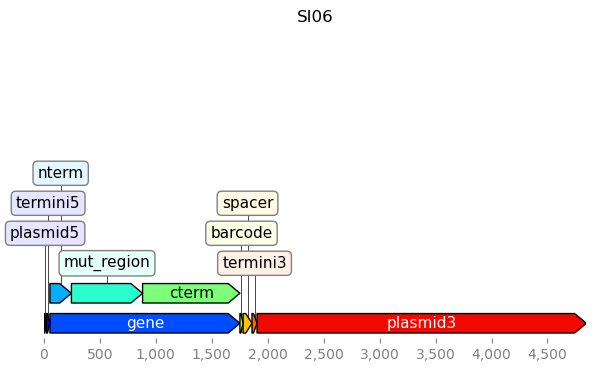

In [9]:
#generates a line plot showing the different annotations of the target, just to confirm
fig = targets.plot(ax_width=7,
                   plots_indexing='biopython',  # numbering starts at 0
                   ax_height=4,  # height of each plot
                   hspace=1.2,  # vertical space between plots
                   )

plotfile = os.path.join(config['process_ccs_dir'], 'amplicons_'+background+'.pdf')
print(f"Saving plot to {plotfile}")
fig.savefig(plotfile, bbox_inches='tight')

In [10]:
#this sets the mapper to the minimap2, use OPTIONS_CODON_DMS which is good for sequences without large deletions and/or introns
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

#This will print out the minimap2 version and the options included with OPTIONS_CODON_DMS, you can find the description of these options on bloom's website
print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.22-r1101 with these options:
-A2 -B4 -O12 -E2 --end-bonus=13 --secondary=no --cs


In [11]:
#this will align and parse the reads and provide the readstats for the aligned and filtered (based on the feature_parse_specs config)
#this is the longest step of the whole process
readstats, aligned, filtered = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=config['process_ccs_dir'],
        name_col='run',
        group_cols=['name', 'library'],
        queryfile_col='fastq',
        overwrite=True,
        ncpus=config['max_cpus'],
        )

In [12]:
readstats

,name,library,run,category,count
0,rep1_SI06_A,rep1,A,aligned SI06,873660
1,rep1_SI06_A,rep1,A,filtered SI06,97384
2,rep1_SI06_A,rep1,A,unmapped,24641
3,rep1_SI06_B,rep1,B,aligned SI06,841438
4,rep1_SI06_B,rep1,B,filtered SI06,101551
5,rep1_SI06_B,rep1,B,unmapped,22364
6,rep2_SI06_A,rep2,A,aligned SI06,1313702
7,rep2_SI06_A,rep2,A,filtered SI06,141226
8,rep2_SI06_A,rep2,A,unmapped,21318


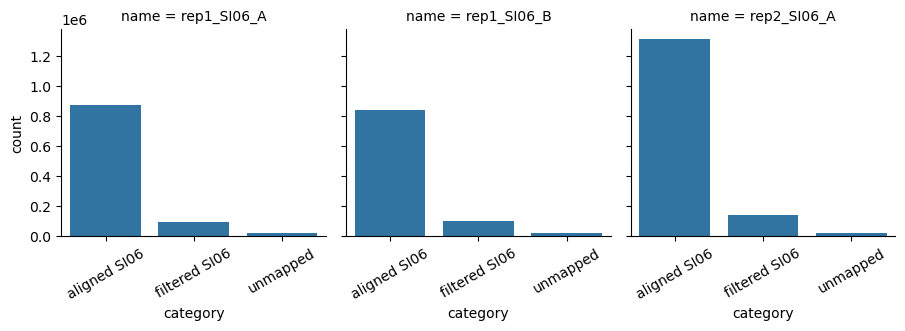

In [13]:
g = sns.FacetGrid(readstats, col='name', col_wrap=4)
g.map_dataframe(sns.barplot, x='category', y='count')
#g.tick_params(labelrotation=90)
g.set_xticklabels(rotation=30)

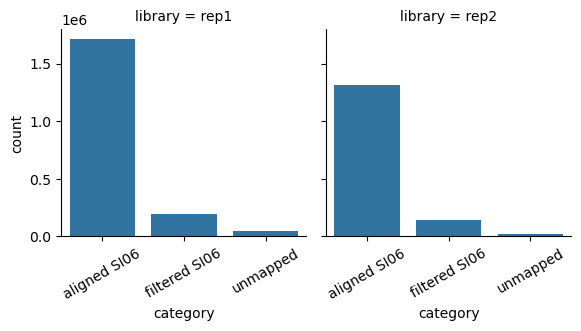

In [14]:
g = sns.FacetGrid(readstats.groupby(['library', 'category']).sum().reset_index(), col='library', col_wrap=2)
g.map_dataframe(sns.barplot, x='category', y='count')
#g.tick_params(labelrotation=90)
g.set_xticklabels(rotation=30)

In [15]:
filtered_df = pd.concat(df.assign(target=target) for target, df in filtered.items())
filtered_df = filtered_df.groupby(['library', 'name', 'run', 'filter_reason']).size().rename('count').reset_index()
filtered_df['tot_reason_frac'] = filtered_df.groupby('filter_reason')['count'].transform('sum') / filtered_df['count'].sum()
other_cutoff = 0.02  # group as "other" reasons with <= this frac
filtered_df['filter_reason'] = filtered_df['filter_reason'].where(filtered_df['tot_reason_frac'] > other_cutoff, 'other')

In [16]:
pd.set_option('display.max_rows', None)
filtered_df

,library,name,run,filter_reason,count,tot_reason_frac
0,rep1,rep1_SI06_A,A,other,128,0.001446
1,rep1,rep1_SI06_A,A,barcode mutation_nt_count,41289,0.415950
2,rep1,rep1_SI06_A,A,other,112,0.001367
3,rep1,rep1_SI06_A,A,gene clip3,2003,0.024309
4,rep1,rep1_SI06_A,A,other,656,0.008446
5,rep1,rep1_SI06_A,A,other,29,0.000176
6,rep1,rep1_SI06_A,A,other,29,0.000232
7,rep1,rep1_SI06_A,A,plasmid3 clip3,17443,0.178845
8,rep1,rep1_SI06_A,A,other,11,0.000085
9,rep1,rep1_SI06_A,A,plasmid5 clip5,24136,0.257290


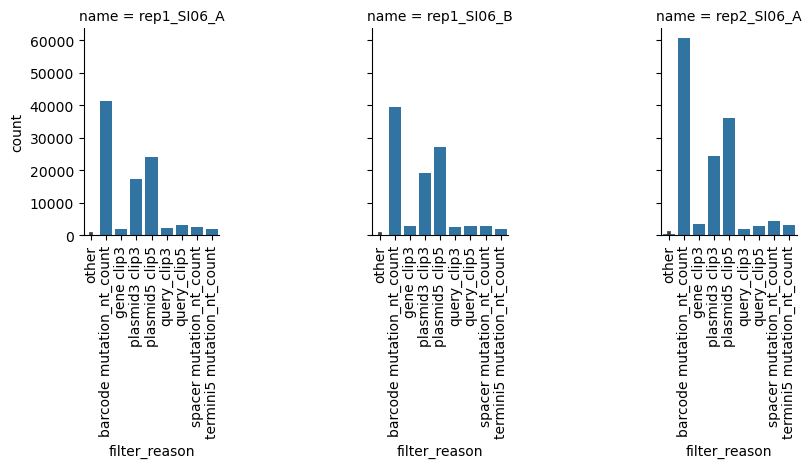

In [17]:
#plot why reads were filtered out, this can direct you to adjust the feature_parse_specs file
g = sns.FacetGrid(filtered_df, col='name')
g.map_dataframe(sns.barplot, x='filter_reason', y='count', order=filtered_df['filter_reason'].unique())
#g.tick_params(labelrotation=90)
g.set_xticklabels(rotation=90)

In [18]:
pd.set_option('display.max_rows', 10)
aligned_df = pd.concat([df.assign(target=target) for target, df in aligned.items()])
aligned_df = aligned_df.drop(columns=['query_clip5', 'query_clip3', 'run','name'])
aligned_df = aligned_df.rename(columns={'barcode_sequence': 'barcode'})
aligned_df

,library,query_name,gene_mutations,gene_accuracy,nterm_mutations,nterm_accuracy,mut_region_mutations,mut_region_accuracy,cterm_mutations,cterm_accuracy,barcode,barcode_accuracy,target
0,rep1,m64408e_230604_130039/1/ccs,T400A T401A C402T del504to504,0.999875,,1.000000,T208A T209A C210T del312to312,0.999686,,0.999986,TTGCTCCGATGGAGCTCTCTACAATCGG,1.000000,SI06
1,rep1,m64408e_230604_130039/5/ccs,C595A C596A T597A ins1233AG ins1363GAAG,0.998498,,0.997926,C403A C404A T405A,0.999491,ins405AG ins535GAAG,0.997903,TTGCAAAGGGTAAGCTGCGTATAGGGTC,1.000000,SI06
2,rep1,m64408e_230604_130039/7/ccs,del676to676 T677C C680A del700to700 del1168to1168,0.999518,,0.999827,del484to484 T485C C488A del508to508,0.999632,del340to340,0.999367,TTGCTTTGGACAAGCTACGGTCAAGGAC,1.000000,SI06
3,rep1,m64408e_230604_130039/8/ccs,del504to504 del757to757,0.999852,,1.000000,del312to312 del565to565,0.999603,,1.000000,TTGCTGAAGGATAGCTGGCAAAGTGAGT,1.000000,SI06
4,rep1,m64408e_230604_130039/16/ccs,,1.000000,,1.000000,,1.000000,,1.000000,TTGCTAATAGCGAGCTTAATCTCCCCGT,1.000000,SI06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028795,rep2,m64408e_230603_035327/180554559/ccs,T376A C377G T378A,1.000000,,1.000000,T184A C185G T186A,1.000000,,1.000000,TTGCTCAGGTACAGCTAAGAGTTAGCGA,1.000000,SI06
3028796,rep2,m64408e_230603_035327/180554568/ccs,,1.000000,,1.000000,,1.000000,,1.000000,TTGCGGCTTCAAAGCTGCGGGTGGTACT,1.000000,SI06
3028797,rep2,m64408e_230603_035327/180554583/ccs,C244T C245A A246T,1.000000,,1.000000,C52T C53A A54T,1.000000,,1.000000,TTGCCTGAATCAAGCTTACGGTTAAGAC,1.000000,SI06
3028798,rep2,m64408e_230603_035327/180554586/ccs,C421T C422A C423T,1.000000,,1.000000,C229T C230A C231T,1.000000,,1.000000,TTGCGAACACCGAGCTGCCAACTCGCCG,1.000000,SI06


In [19]:
#this saves the processed ccs file
aligned_df.to_csv(config['processed_ccs_file' + '_' + background], index=False)


print("Barcodes and mutations for valid processed CCSs "
      f"have been written to {config['processed_ccs_file' + '_' + background]}.")

Barcodes and mutations for valid processed CCSs have been written to results/process_ccs/processed_ccs_SI06.csv.


In [20]:
os.makedirs(config['variants_dir'], exist_ok=True)
os.makedirs(config['figs_dir'], exist_ok=True)

In [21]:
processed_ccs = pd.read_csv(config['processed_ccs_file' + '_' + background], na_filter=None)

nlibs = processed_ccs['library'].nunique()  # number of unique libraries

ntargets = processed_ccs['target'].nunique()  # number of unique targets

print(f"Read {len(processed_ccs)} CCSs from {nlibs} libraries and {ntargets} targets.")

Read 3028800 CCSs from 2 libraries and 1 targets.


In [22]:
#displays number of CCSs and unique barcodes in all processed targets/reps
display_ccs = processed_ccs.groupby(['target', 'library']).aggregate(total_CCSs=('barcode', 'size'),
                                                                     unique_barcodes=('barcode', 'nunique'))
display_ccs['avg_CCSs_per_barcode'] = display_ccs['total_CCSs'] / display_ccs['unique_barcodes']
display_ccs['avg_CCSs_per_barcode'] = display_ccs['avg_CCSs_per_barcode'].round(2)

display_ccs

total_CCSs  unique_barcodes  avg_CCSs_per_barcode
target library                                                   
SI06   rep1        1715098           253660                  6.76
       rep2        1313702           192183                  6.84

In [23]:
#set max_error_rate in config.yaml file

error_rate_floor = 1e-7  # error rates < this set to this
if error_rate_floor >= config['max_error_rate']:
    raise ValueError('error_rate_floor must be < max_error_rate')
    
processed_ccs['barcode_error'] = (1-processed_ccs['barcode_accuracy']).clip(lower=error_rate_floor)
processed_ccs['gene_error'] = (1-processed_ccs['gene_accuracy']).clip(lower=error_rate_floor)

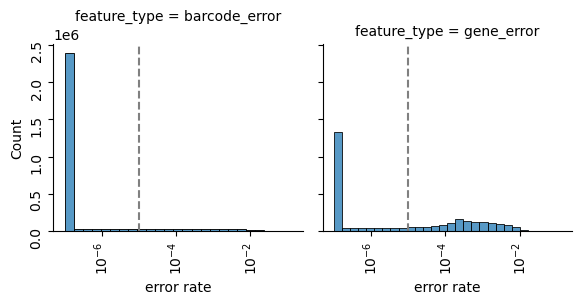

In [24]:
#plot error rates
g = sns.FacetGrid(processed_ccs.melt(value_vars=['barcode_error', 'gene_error'],
              var_name='feature_type', value_name='error rate'), col='feature_type')
g.map_dataframe(sns.histplot, x='error rate', bins=25, log_scale=True)
g.refline(x=config['max_error_rate'])
g.tick_params(labelrotation=90)

In [25]:
processed_ccs['retained'] = ((processed_ccs['gene_error'] < config['max_error_rate']) &
                              (processed_ccs['barcode_error']    < config['max_error_rate']))

In [26]:
#retained based on error rate
data = processed_ccs.assign(xlabel=lambda x: x['target'] + ', ' + x['library']).groupby(['xlabel', 'retained']).size().rename('count').reset_index()
data

,xlabel,retained,count
0,"SI06, rep1",False,748268
1,"SI06, rep1",True,966830
2,"SI06, rep2",False,591533
3,"SI06, rep2",True,722169


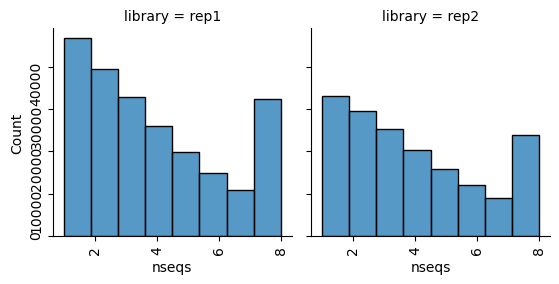

In [27]:
#plot histogram for how many barcodes have how many CCSs associated with them
max_count = 8 # in plot, group all barcodes with >= this many counts

data = processed_ccs.query('retained').groupby(['library', 'barcode']).size().rename('nseqs').reset_index()
data['nseqs'] = data['nseqs'].clip(upper=max_count)

g = sns.FacetGrid(data, col='library')
g.map_dataframe(sns.histplot, x='nseqs', bins=8)
g.tick_params(labelrotation=90)

In [28]:
processed_ccs = processed_ccs.reset_index(drop=True)

#add indel columns, what you put as mutation_col is where it will look to see if there are indels there
processed_ccs = alignparse.consensus.add_mut_info_cols(processed_ccs,
                                                       mutation_col=considered_region,
                                                       n_indel_col='n_indels',
                                                       del_str_col='del',
                                                       n_del_col='n_dels',
                                                       n_ins_col='n_ins')

processed_ccs['has_indel'] = (processed_ccs['n_indels'] > 0).astype(bool)
processed_ccs['has_ins'] = (processed_ccs['n_ins'] > 0).astype(bool)
processed_ccs['has_del'] = (processed_ccs['n_dels'] > 0).astype(bool)

In [29]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
processed_ccs

,library,query_name,gene_mutations,gene_accuracy,nterm_mutations,nterm_accuracy,mut_region_mutations,mut_region_accuracy,cterm_mutations,cterm_accuracy,barcode,barcode_accuracy,target,barcode_error,gene_error,retained,del,n_dels,n_ins,n_indels,has_indel,has_ins,has_del
0,rep1,m64408e_230604_130039/1/ccs,T400A T401A C402T del504to504,0.999875,,1.000000,T208A T209A C210T del312to312,0.999686,,0.999986,TTGCTCCGATGGAGCTCTCTACAATCGG,1.000000,SI06,1.000000e-07,1.249949e-04,False,del504to504,1,0,1,True,False,True
1,rep1,m64408e_230604_130039/5/ccs,C595A C596A T597A ins1233AG ins1363GAAG,0.998498,,0.997926,C403A C404A T405A,0.999491,ins405AG ins535GAAG,0.997903,TTGCAAAGGGTAAGCTGCGTATAGGGTC,1.000000,SI06,1.000000e-07,1.501965e-03,False,,0,2,2,True,True,False
2,rep1,m64408e_230604_130039/7/ccs,del676to676 T677C C680A del700to700 del1168to1168,0.999518,,0.999827,del484to484 T485C C488A del508to508,0.999632,del340to340,0.999367,TTGCTTTGGACAAGCTACGGTCAAGGAC,1.000000,SI06,1.000000e-07,4.820043e-04,False,del676to676 del700to700 del1168to1168,3,0,3,True,False,True
3,rep1,m64408e_230604_130039/8/ccs,del504to504 del757to757,0.999852,,1.000000,del312to312 del565to565,0.999603,,1.000000,TTGCTGAAGGATAGCTGGCAAAGTGAGT,1.000000,SI06,1.000000e-07,1.482554e-04,False,del504to504 del757to757,2,0,2,True,False,True
4,rep1,m64408e_230604_130039/16/ccs,,1.000000,,1.000000,,1.000000,,1.000000,TTGCTAATAGCGAGCTTAATCTCCCCGT,1.000000,SI06,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028795,rep2,m64408e_230603_035327/180554559/ccs,T376A C377G T378A,1.000000,,1.000000,T184A C185G T186A,1.000000,,1.000000,TTGCTCAGGTACAGCTAAGAGTTAGCGA,1.000000,SI06,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False
3028796,rep2,m64408e_230603_035327/180554568/ccs,,1.000000,,1.000000,,1.000000,,1.000000,TTGCGGCTTCAAAGCTGCGGGTGGTACT,1.000000,SI06,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False
3028797,rep2,m64408e_230603_035327/180554583/ccs,C244T C245A A246T,1.000000,,1.000000,C52T C53A A54T,1.000000,,1.000000,TTGCCTGAATCAAGCTTACGGTTAAGAC,1.000000,SI06,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False
3028798,rep2,m64408e_230603_035327/180554586/ccs,C421T C422A C423T,1.000000,,1.000000,C229T C230A C231T,1.000000,,1.000000,TTGCGAACACCGAGCTGCCAACTCGCCG,1.000000,SI06,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False


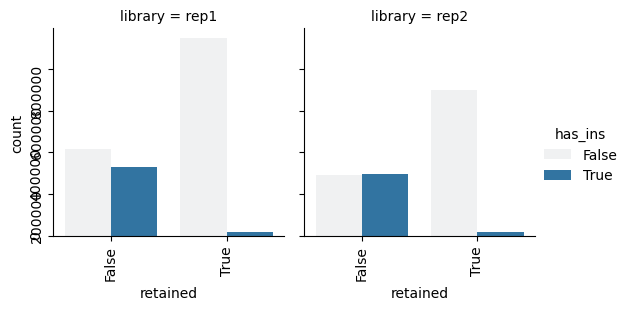

In [30]:
#plot whether the sequences retained after the error rate filter have insertions

g = sns.FacetGrid(processed_ccs, col='library')
g.map_dataframe(sns.countplot, x='retained', hue='has_ins')
g.tick_params(labelrotation=90)
g.add_legend(title='has_ins')

In [31]:
high_acc = config['max_error_rate'] / 10
empirical_acc = []

for desc, query_str in [
        ('retained', 'retained'),
        ('retained, no ins', 'retained and not has_ins'),
        ('10X accuracy', f"(gene_error < {high_acc}) and (barcode_error < {high_acc})"),
        ('10X accuracy, no ins', f"(gene_error < {high_acc}) and (barcode_error < {high_acc}) and not has_ins")
        ]:
    # get just CCSs in that category
    query_df = processed_ccs.query(query_str)
        
    # compute empirical accuracy
    emp_acc_df = alignparse.consensus.empirical_accuracy(query_df,
                                                mutation_col=considered_region,
                                                group_cols='barcode',
                                                accuracy_col='accuracy',
                                               )
    emp_acc_df['description'] = desc
    query_df = emp_acc_df.merge(query_df.groupby('library').size().rename('number_CCSs').reset_index())
    empirical_acc.append(query_df)

# make description categorical to preserve order, and annotate as "actual"
# the category ("retained, no indel") that we will use for building variants.
empirical_acc = pd.concat(empirical_acc, ignore_index=True, sort=False)
empirical_acc['description'] = pd.Categorical(empirical_acc['description'],
                                                 empirical_acc['description'].unique(),
                                                 ordered=True)
empirical_acc['actual'] = np.where(empirical_acc['description'] == 'retained, no ins', True, False)

In [32]:
empirical_acc

,library,accuracy,description,number_CCSs,actual
0,rep1,0.930090,retained,966830,False
1,rep2,0.924470,retained,722169,False
2,rep1,0.946025,"retained, no ins",947471,True
3,rep2,0.948135,"retained, no ins",701601,True
4,rep1,0.945245,10X accuracy,843699,False
5,rep2,0.940601,10X accuracy,627049,False
6,rep1,0.955781,"10X accuracy, no ins",831789,False
7,rep2,0.956241,"10X accuracy, no ins",614605,False


In [33]:
consensus, dropped = alignparse.consensus.simple_mutconsensus(
                        processed_ccs.query('retained'),
                        group_cols=('library', 'barcode', 'target'),
                        mutation_col=considered_region,
                        )

consensus.head()

,library,barcode,target,gene_mutations,variant_call_support
0,rep1,AAAACTGGTGCTAGCTGGTTTGCAATAA,SI06,T374A A375T ins1699TTGCCTGTAAGTAGCTCGTCGTC,1
1,rep1,AACAATTGGTGCAGCTTAACAGAGTTCC,SI06,ins1698ATTGCCCATTGAGAGCTAATCG,3
2,rep1,AAGCTCGTCTCCAGCTGGCGGTCTGATC,SI06,C595G C596T T597G ins1699TTGCAAAGGGT,1
3,rep1,AAGCTCGTCTCCAGCTTTGACACCACAC,SI06,A508T A509G ins1699TTGCTGCTCCG,1
4,rep1,AATTGCGTCTCCAGCTACCAGCTTCTTC,SI06,C817A T818A G819T A1560C T1561G A1565G C1568A ...,7


In [34]:
consensus = alignparse.consensus.add_mut_info_cols(
                    consensus,
                    mutation_col=considered_region,
                    sub_str_col='substitutions',
                    n_indel_col='number_of_indels',
                    n_ins_col='number_of_insertions',
                    n_del_col='number_of_deletions',
                    del_str_col='deletion',
                    overwrite_cols=True)

consensus

,library,barcode,target,gene_mutations,variant_call_support,substitutions,deletion,number_of_deletions,number_of_insertions,number_of_indels
0,rep1,AAAACTGGTGCTAGCTGGTTTGCAATAA,SI06,T374A A375T ins1699TTGCCTGTAAGTAGCTCGTCGTC,1,T374A A375T,,0,1,1
1,rep1,AACAATTGGTGCAGCTTAACAGAGTTCC,SI06,ins1698ATTGCCCATTGAGAGCTAATCG,3,,,0,1,1
2,rep1,AAGCTCGTCTCCAGCTGGCGGTCTGATC,SI06,C595G C596T T597G ins1699TTGCAAAGGGT,1,C595G C596T T597G,,0,1,1
3,rep1,AAGCTCGTCTCCAGCTTTGACACCACAC,SI06,A508T A509G ins1699TTGCTGCTCCG,1,A508T A509G,,0,1,1
4,rep1,AATTGCGTCTCCAGCTACCAGCTTCTTC,SI06,C817A T818A G819T A1560C T1561G A1565G C1568A ...,7,C817A T818A G819T A1560C T1561G A1565G C1568A ...,del1529to1557 del1575to1578 del1605to1605 del1...,4,1,5
...,...,...,...,...,...,...,...,...,...,...
358883,rep2,TTTCCGAACTTCAGCTATGAAATCCGAC,SI06,A293G,2,A293G,,0,0,0
358884,rep2,TTTCGAAGAGGGAGCTCTTGCACCGAAT,SI06,C621T,1,C621T,,0,0,0
358885,rep2,TTTCGTGACTGGAGCTTTTGACTTTCAC,SI06,ins1699TTGCTACGACCGAGCTCAG,3,,,0,1,1
358886,rep2,TTTCTGGATGTGAGCTAAACTGATCACA,SI06,A679G C680A C681A ins1699TTGCAGATCCCAAGCTCCGCA...,3,A679G C680A C681A,,0,1,1


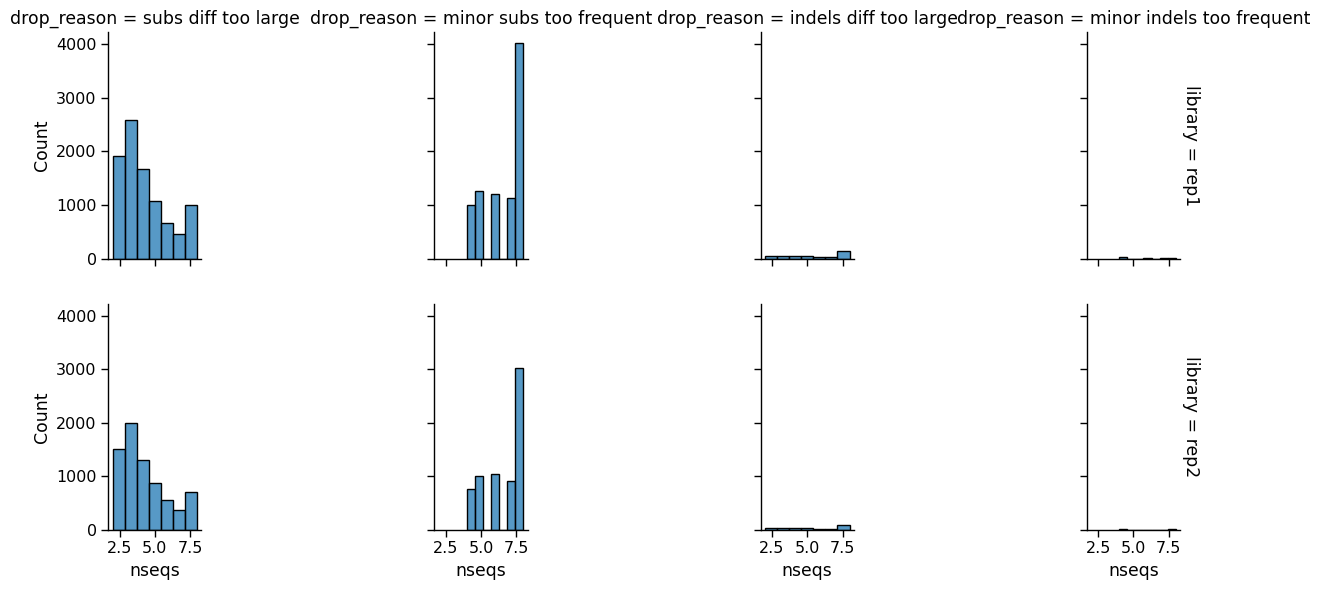

In [35]:
max_nseqs = 8  # plot together all barcodes with >= this many sequences

#below is from https://wckdouglas.github.io/2016/12/seaborn_annoying_title
with sns.plotting_context('paper', font_scale = 1.3):
    p = sns.FacetGrid(data = dropped.assign(nseqs=lambda x: np.clip(x['nseqs'], None, max_nseqs)),
                      col = 'drop_reason',
                      row = 'library',
                      margin_titles=True)
    
p.map_dataframe(sns.histplot, x='nseqs', bins=7) 
plt.subplots_adjust(hspace=0.2, wspace=2.5)

In [36]:
max_variant_call_support = 6  # group variants with >= this much support
consensus['variant_call_support'] = consensus['variant_call_support'].clip(upper=max_variant_call_support)
consensus['ins_state'] = np.where(consensus['number_of_insertions'] > 0, 'has ins', 'no ins')

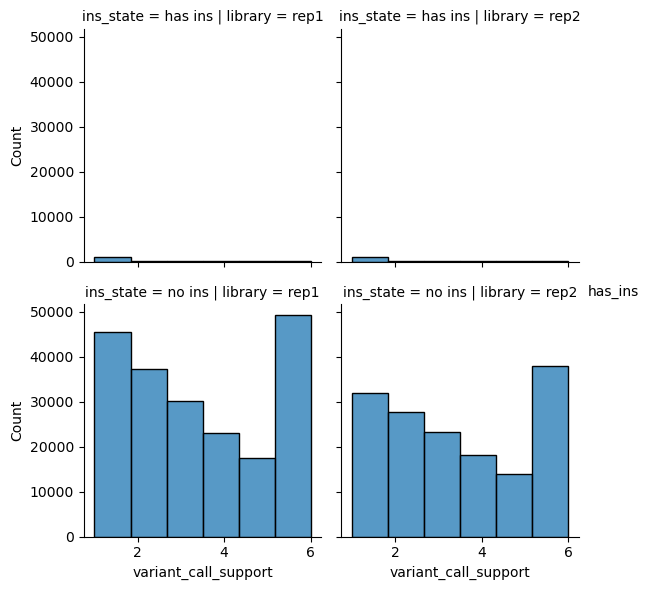

In [37]:
g = sns.FacetGrid(consensus, col='library', row='ins_state')
g.map_dataframe(sns.histplot, x='variant_call_support', bins=6)
g.add_legend(title='has_ins')

In [38]:
consensus=consensus.query('number_of_insertions == 0')
consensus=consensus.query('number_of_deletions <= 1')

In [39]:
#change dels to -, determine if deletion is out of frame and remove any that are not in frame
if considered_region == 'gene_mutations':
    region_seq = targets.get_target(background).get_feature('gene').seq
if considered_region == 'mut_region_mutations':
    region_seq = targets.get_target(background).get_feature('mut_region').seq
    
consensus.reset_index(drop=True)

deltosubs=InFrameDeletionsToSubs(region_seq)
new_subs=[]
for x in consensus[considered_region]:  
    new_subs.append(deltosubs.dels_to_subs(x))
consensus['substitutions']=new_subs
consensus['deletion_out_of_frame']=consensus['substitutions'].str.contains('del')
consensus=consensus[consensus['deletion_out_of_frame']==False]
consensus=consensus.drop(['deletion'],axis='columns')
consensus

,library,barcode,target,gene_mutations,variant_call_support,substitutions,number_of_deletions,number_of_insertions,number_of_indels,ins_state,deletion_out_of_frame
96,rep1,AGTGACATCTGGAGCTGCCCCTCATCTC,SI06,T736G A737G C738A,6,T736G A737G C738A,0,0,0,no ins,False
97,rep1,AGTGACATCTGGAGCTGTTAATATTGTT,SI06,T736G A737G C738A,6,T736G A737G C738A,0,0,0,no ins,False
211,rep1,ATGCACGGCGATAGCTCCAATTCCGATT,SI06,G691C C692A C693A,6,G691C C692A C693A,0,0,0,no ins,False
212,rep1,ATGCCGCCACTTAGCTTTATCGCTCTCA,SI06,T418G G419A G420A,4,T418G G419A G420A,0,0,0,no ins,False
213,rep1,ATGCCTGGCTCTAGCTAGTCTTACGTCG,SI06,T265C C266A C267T,3,T265C C266A C267T,0,0,0,no ins,False
...,...,...,...,...,...,...,...,...,...,...,...
358880,rep2,TTTCAATCGTAGAGCTCCATAACTGTAT,SI06,del742to744,1,A742- C743- T744-,1,0,1,no ins,False
358881,rep2,TTTCAGGTCTCCAGCTACTAATAATTGA,SI06,A367G G368C T369A,6,A367G G368C T369A,0,0,0,no ins,False
358882,rep2,TTTCATGTCGGGAGCTAGACAGGGTACC,SI06,G706A T707G,1,G706A T707G,0,0,0,no ins,False
358883,rep2,TTTCCGAACTTCAGCTATGAAATCCGAC,SI06,A293G,2,A293G,0,0,0,no ins,False


In [40]:
print(f"Writing nucleotide variants to {config['nt_variant_table_file' + '_' + background]}")
      
(consensus
 [['target', 'library', 'barcode', considered_region,'substitutions', 'variant_call_support']]
 .to_csv(config['nt_variant_table_file' + '_' + background], index=False)
 )
      
print('Here are the first few lines of this file:')
display(HTML(
    pd.read_csv(config['nt_variant_table_file' + '_' + background], na_filter=None)
    .head()
    .to_html(index=False)
    )) 

Writing nucleotide variants to results/variants/nucleotide_variant_table_SI06.csv
Here are the first few lines of this file:


target,library,barcode,gene_mutations,substitutions,variant_call_support
SI06,rep1,AGTGACATCTGGAGCTGCCCCTCATCTC,T736G A737G C738A,T736G A737G C738A,6
SI06,rep1,AGTGACATCTGGAGCTGTTAATATTGTT,T736G A737G C738A,T736G A737G C738A,6
SI06,rep1,ATGCACGGCGATAGCTCCAATTCCGATT,G691C C692A C693A,G691C C692A C693A,6
SI06,rep1,ATGCCGCCACTTAGCTTTATCGCTCTCA,T418G G419A G420A,T418G G419A G420A,4
SI06,rep1,ATGCCTGGCTCTAGCTAGTCTTACGTCG,T265C C266A C267T,T265C C266A C267T,3


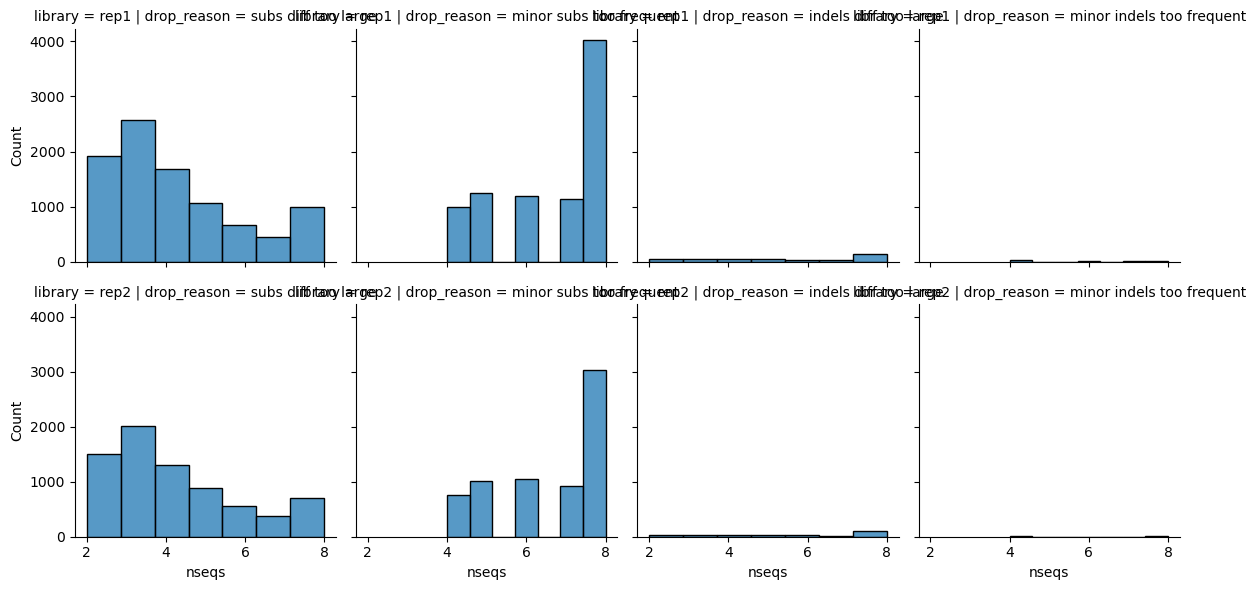

In [41]:
max_nseqs = 8  # plot together all barcodes with >= this many sequences

g = sns.FacetGrid(dropped.assign(nseqs=lambda x: np.clip(x['nseqs'], None, max_nseqs)),
                  col='drop_reason', row='library')
g.map_dataframe(sns.histplot, x='nseqs', bins=7)


In [42]:
targets = alignparse.targets.Targets(seqsfile=config['amplicons_' + background],
                                     feature_parse_specs=config['feature_parse_specs_' + background])
geneseq = targets.get_target(background).get_feature('gene').seq

print(f"Read gene of {len(geneseq)} nts for {background} from {config['amplicons_' + background]}")
     

Read gene of 1698 nts for SI06 from data/SI06.gb


In [43]:
variants = dms_variants.codonvarianttable.CodonVariantTable(
                barcode_variant_file=config['nt_variant_table_file_' + background],
                geneseq=geneseq,
                primary_target=background,
                allowgaps=True,
                substitutions_col='substitutions'
                )

In [44]:
print('Number of variants for each replicate:')
display(HTML(
    variants
    .n_variants_df(samples=None)
    .pivot_table(index=['target'],
                 columns='library',
                 values='count')
    .to_html()
    ))

Number of variants for each replicate:


library,rep1,rep2,all libraries
target,,,
SI06,200017,151325,351342


In [45]:
variants_df=variants.barcode_variant_df
variants_df

,target,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,SI06,rep1,AGTGACATCTGGAGCTGCCCCTCATCTC,6,TAC246GGA,Y246G,1,1
1,SI06,rep1,AGTGACATCTGGAGCTGTTAATATTGTT,6,TAC246GGA,Y246G,1,1
2,SI06,rep1,ATGCACGGCGATAGCTCCAATTCCGATT,6,GCC231CAA,A231Q,1,1
3,SI06,rep1,ATGCCGCCACTTAGCTTTATCGCTCTCA,4,TGG140GAA,W140E,1,1
4,SI06,rep1,ATGCCTGGCTCTAGCTAGTCTTACGTCG,3,TCC89CAT,S89H,1,1
...,...,...,...,...,...,...,...,...
351337,SI06,rep2,TTTCAATCGTAGAGCTCCATAACTGTAT,1,ACT248---,T248-,1,1
351338,SI06,rep2,TTTCAGGTCTCCAGCTACTAATAATTGA,6,AGT123GCA,S123A,1,1
351339,SI06,rep2,TTTCATGTCGGGAGCTAGACAGGGTACC,1,GTA236AGA,V236R,1,1
351340,SI06,rep2,TTTCCGAACTTCAGCTATGAAATCCGAC,2,GAA98GGA,E98G,1,1


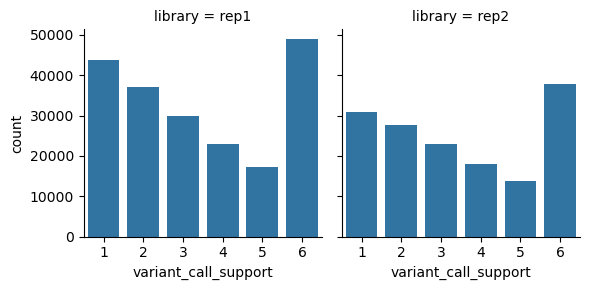

In [46]:
#show distribution of sequences with x number of ccs supporting each variant
g = sns.FacetGrid(variants_df, col='library')
g.map_dataframe(sns.countplot, x='variant_call_support')
g.tick_params(labelrotation=0)

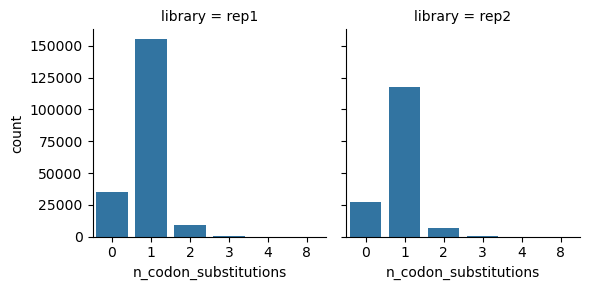

In [47]:
#show distribution of sequences with x number of codon substitutions
g = sns.FacetGrid(variants_df, col='library')
g.map_dataframe(sns.countplot, x='n_codon_substitutions')
g.tick_params(labelrotation=0)

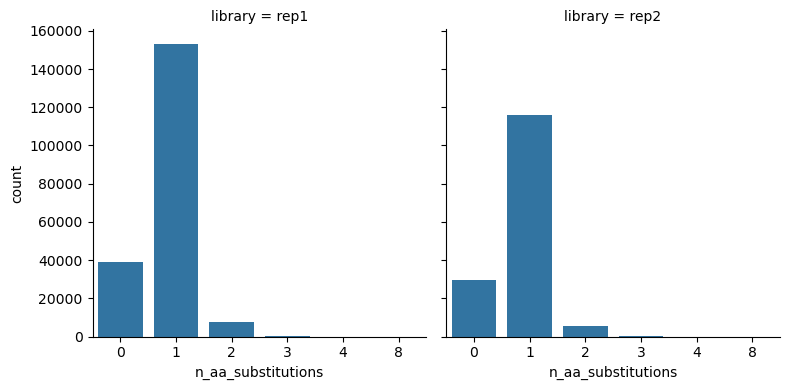

In [48]:
#show distribution of sequences with x number of amino acid substitutions
g = sns.FacetGrid(variants_df, col='library', height=4)
g.map_dataframe(sns.countplot, x='n_aa_substitutions')
g.tick_params(labelrotation=0)

In [49]:
display(HTML(
    variants.barcode_variant_df
    .head()
    .to_html(index=False)
    ))

target,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
SI06,rep1,AGTGACATCTGGAGCTGCCCCTCATCTC,6,TAC246GGA,Y246G,1,1
SI06,rep1,AGTGACATCTGGAGCTGTTAATATTGTT,6,TAC246GGA,Y246G,1,1
SI06,rep1,ATGCACGGCGATAGCTCCAATTCCGATT,6,GCC231CAA,A231Q,1,1
SI06,rep1,ATGCCGCCACTTAGCTTTATCGCTCTCA,4,TGG140GAA,W140E,1,1
SI06,rep1,ATGCCTGGCTCTAGCTAGTCTTACGTCG,3,TCC89CAT,S89H,1,1


In [50]:
print(f"Writing codon-variant table to {config['codon_variant_table_file_'+background]}")
print(f"Writing single codon-variant table to {config['codon_variant_table_file_'+background+'_single']}")


variants_df=variants.barcode_variant_df
variants_df.to_csv(config['codon_variant_table_file_'+background], index=False)
variants_df.query('n_codon_substitutions <= 1').to_csv(config['codon_variant_table_file_'+background+'_single'], index=False)

Writing codon-variant table to results/variants/codon_variant_table_SI06.csv
Writing single codon-variant table to results/variants/codon_variant_table_SI06_single.csv
